In [63]:
import numpy as np
import pandas as pd

df = pd.read_csv('./Train_X.csv',encoding= 'cp950')

In [76]:
df = df.sort_values('日期')

In [78]:
df

,日期,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅...,振幅...,...,市值比重...,本益比,股價淨值比,本益比.近四季.,週轉率...,成交值比重...,漲跌停,均價,成交量.股.,RTIME
29038,20140102,2455,全新,30.50,30.90,30.15,30.60,0.20,0.66,2.47,...,0.031,14.5,2.18,16.2,0.79,0.065,0.0,30.51,1.964103e+06,123459.0
30285,20140102,TWC31,OTC光電,31.77,31.90,31.51,31.80,0.02,0.06,1.23,...,7.083,89.9,1.37,NaN,1.83,10.504,NaN,38.91,7.827124e+07,123459.0
30295,20140102,TWTB1,指標公債指數,1042.13,1042.13,1040.55,1041.68,-0.33,-0.03,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1041.68,0.000000e+00,NaN
30294,20140102,TWC99,OTC其他類,NaN,NaN,NaN,NaN,0.00,0.00,NaN,...,5.989,21.4,2.41,NaN,0.58,2.821,NaN,34.86,2.346600e+07,123459.0
30293,20140102,TWC60,櫃買富櫃五十報酬指數,NaN,NaN,NaN,180.30,1.74,0.97,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.30,NaN,NaN
30292,20140102,TWC51,櫃買線上遊戲業,92.08,92.76,91.13,91.27,-0.63,-0.69,1.77,...,1.647,37.1,2.04,NaN,1.44,1.915,NaN,52.80,1.051804e+07,123459.0
30291,20140102,TWC50,櫃買富櫃五十指數,154.41,155.67,154.36,155.57,1.50,0.97,0.85,...,44.609,18.0,2.67,NaN,0.99,35.875,NaN,68.92,1.509155e+08,123459.0
30290,20140102,TWC36,OTC其他電子,NaN,NaN,NaN,NaN,0.00,0.00,NaN,...,4.648,18.2,1.94,NaN,1.12,4.205,NaN,47.08,2.589596e+07,123459.0
30289,20140102,TWC35,OTC資訊服務,99.98,100.24,98.92,99.03,-0.40,-0.40,1.33,...,3.780,27.9,2.82,NaN,1.08,3.319,NaN,61.92,1.554088e+07,123459.0
30288,20140102,TWC34,OTC電子通路,65.06,65.85,64.97,65.54,1.06,1.64,1.36,...,0.775,26.5,1.15,NaN,0.95,0.598,NaN,16.77,1.033941e+07,123459.0


In [72]:
stock_list = (df['股票代號'].unique()).tolist()

In [79]:
#df[df['股票代號']==stock_list[0]]['收盤價']

In [98]:
data = {}
for name in stock_list:
    data[name]=df[df['股票代號']==name].loc[:,['開盤價', '最高價','最低價','收盤價','成交量.股.']]

In [135]:
#定義正規化函式
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

a= normalize(data['2455'])
a.head(10)

,開盤價,最高價,最低價,收盤價,成交量.股.
29038,0.017632,0.026985,0.017051,0.035465,-0.013452
27360,0.012045,-0.023862,0.017051,-0.010689,-0.063189
25680,0.000872,0.043934,0.022179,0.035465,0.007484
24000,0.051151,0.026985,0.042692,0.045721,-0.057653
22319,0.062325,0.038285,0.052948,0.045721,-0.020774
20638,0.056738,0.060883,0.011923,-0.005561,-0.011409
18957,-0.015888,-0.006913,0.022179,-0.000433,-0.070987
17276,-0.010301,0.055234,0.027307,0.091875,0.008359
15593,0.090258,0.106081,0.068333,0.040593,0.118870
13909,0.051151,0.026985,0.058076,0.040593,-0.056160


In [185]:
#定義餵入的feature跟label序列
def train_(df, ref_day=10, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]['收盤價']))
    return np.array(X_train), np.array(Y_train)

In [186]:
X,Y=train_(a,5,1)
split_boundary = int(X.shape[0] * 0.9)
train_x = X[: split_boundary]
test_x = X[split_boundary:]
train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

In [187]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_x.shape[1], train_x.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(train_x, train_y, epochs = 100, batch_size = 32)

Epoch 1/100
207/207 [==============================] - 4s 18ms/step - loss: 0.0444
Epoch 2/100
207/207 [==============================] - 0s 845us/step - loss: 0.0383
Epoch 3/100
207/207 [==============================] - 0s 801us/step - loss: 0.0233
Epoch 4/100
207/207 [==============================] - 0s 855us/step - loss: 0.0137
Epoch 5/100
207/207 [==============================] - 0s 792us/step - loss: 0.0118
Epoch 6/100
207/207 [==============================] - 0s 821us/step - loss: 0.0128
Epoch 7/100
207/207 [==============================] - 0s 879us/step - loss: 0.0115
Epoch 8/100
207/207 [==============================] - 0s 859us/step - loss: 0.0117
Epoch 9/100
207/207 [==============================] - 0s 879us/step - loss: 0.0115
Epoch 10/100
207/207 [==============================] - 0s 859us/step - loss: 0.0119
Epoch 11/100
207/207 [==============================] - 0s 835us/step - loss: 0.0115
Epoch 12/100
207/207 [==============================] - 0s 826us/step - los

207/207 [==============================] - 0s 797us/step - loss: 0.0044
Epoch 98/100
207/207 [==============================] - 0s 879us/step - loss: 0.0049
Epoch 99/100
207/207 [==============================] - 0s 763us/step - loss: 0.0050
Epoch 100/100
207/207 [==============================] - 0s 888us/step - loss: 0.0051


In [188]:
#估算test
regressor.evaluate(test_x,test_y)

24/24 [==============================] - 1s 28ms/step


0.002489656675606966

In [189]:
predict_y = regressor.predict(test_x)

In [190]:
def denormalize(train):
    denorm = train*(np.max(data['2455']['收盤價'])-np.min(data['2455']['收盤價']))+np.mean(data['2455']['收盤價'])
    return denorm

In [191]:
test_y = pd.DataFrame(test_y)
test_y = denormalize(test_y)
z = denormalize(predict_y)

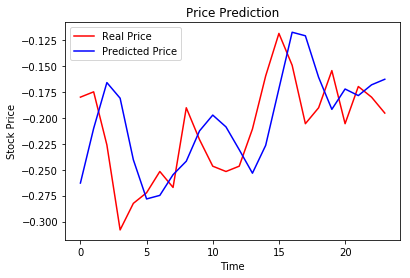

In [192]:
import matplotlib.pyplot as plt 
plt.plot(test_y, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(z, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()